## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

# Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, classification_report, confusion_matrix
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

## Load Dataset

In [2]:
# Load the cleaned insurance dataset
df = pd.read_csv(r"C:\MyData\Workspace\mini_capstone\data\insurance_cleaned.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Define column types
num_cols = ["age", "bmi", "children"]
cat_cols_reg = ["sex", "smoker", "region"]  # For regression (predicting charges)
cat_cols_clf = ["sex", "region"]  # For classification (predicting smoker)

## Categorical Encoding & Feature Scaling
Create preprocessors for both regression and classification tasks

In [4]:
# Preprocessor for Regression (predicting charges)
prep_reg = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_reg)
])

# Preprocessor for Classification (predicting smoker)
prep_clf = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_clf)
])

## Train-Test Split
Split data for both regression and classification tasks

In [5]:
# Regression task: Predicting charges
X = df.drop(columns=["charges"])
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Classification task: Predicting smoker (stratified to maintain class balance)
# We drop 'charges' as well to prevent data leakage, as charges are determined
# based on factors including smoking status.
X_clf = df.drop(columns=["smoker", "charges"])
y_clf = df["smoker"]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=42
)

## Cross-Validation and Scoring
Define cross-validation strategies and scoring metrics

In [6]:
# Cross-validation for Regression
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

# Scoring metrics for Regression
scoring_reg = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

# Cross-validation for Classification (Stratified)
cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scoring metrics for Classification
scoring_clf = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average='weighted', zero_division=0),
    "recall": make_scorer(recall_score, average='weighted', zero_division=0),
    "f1": make_scorer(f1_score, average='weighted', zero_division=0),
    "roc_auc": "roc_auc"
}

## Handling Class Imbalance - SMOTE
Apply SMOTE for classification tasks to balance classes

In [7]:
# Check class imbalance
print("Original class distribution:")
print(y_train_clf.value_counts())
print(f"\nClass ratio: {y_train_clf.value_counts().min() / y_train_clf.value_counts().max():.2%}")

# SMOTE will be applied within pipeline for classification models
smote = SMOTE(random_state=42)

Original class distribution:
smoker
no     850
yes    219
Name: count, dtype: int64

Class ratio: 25.76%


## Apply SMOTE to All Classification Models
Train all classification models with SMOTE to handle class imbalance

In [8]:
# Define all classification models with SMOTE in ImbPipeline
classification_models_dict = {
    "Logistic Regression": ImbPipeline([
        ("preprocess", prep_clf),
        ("smote", SMOTE(random_state=42)),
        ("classifier", LogisticRegression(class_weight="balanced", solver='liblinear'))
    ]),
    "K-Nearest Neighbors": ImbPipeline([
        ("preprocess", prep_clf),
        ("smote", SMOTE(random_state=42)),
        ("classifier", KNeighborsClassifier())
    ]),
    "SVM (RBF)": ImbPipeline([
        ("preprocess", prep_clf),
        ("smote", SMOTE(random_state=42)),
        ("classifier", SVC(kernel="rbf", probability=True))
    ]),
    "SVM (Linear)": ImbPipeline([
        ("preprocess", prep_clf),
        ("smote", SMOTE(random_state=42)),
        ("classifier", SVC(kernel="linear", probability=True))
    ]),
    "Decision Tree": ImbPipeline([
        ("preprocess", prep_clf),
        ("smote", SMOTE(random_state=42)),
        ("classifier", DecisionTreeClassifier(class_weight="balanced", random_state=42))
    ]),
    "Random Forest": ImbPipeline([
        ("preprocess", prep_clf),
        ("smote", SMOTE(random_state=42)),
        ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
    ]),
    "Gradient Boosting": ImbPipeline([
        ("preprocess", prep_clf),
        ("smote", SMOTE(random_state=42)),
        ("classifier", GradientBoostingClassifier(random_state=42))
    ]),
    "Stacking Ensemble": ImbPipeline([
        ("preprocess", prep_clf),
        ("smote", SMOTE(random_state=42)),
        ("classifier", StackingClassifier(
            estimators=[
                ("lr", LogisticRegression(max_iter=1000)),
                ("knn", KNeighborsClassifier(n_neighbors=5)),
                ("svc", SVC(kernel="rbf", probability=True))
            ],
            final_estimator=LogisticRegression(),
            passthrough=False
        ))
    ])
}

# Parameter grids for each model with SMOTE
param_grids_smote = {
    "Logistic Regression": {
        "classifier__C": [0.01, 0.1, 1.0, 10.0],
        "classifier__penalty": ["l1", "l2"]
    },
    "K-Nearest Neighbors": {
        "classifier__n_neighbors": [3, 5, 7, 9],
        "classifier__weights": ["uniform", "distance"]
    },
    "SVM (RBF)": {
        "classifier__C": [0.1, 1.0, 10.0],
        "classifier__gamma": ["scale", "auto", 0.1, 1.0]
    },
    "SVM (Linear)": {
        "classifier__C": [0.1, 1.0, 10.0]
    },
    "Decision Tree": {
        "classifier__max_depth": [3, 5, 7, 10],
        "classifier__min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__max_depth": [5, 10, None],
        "classifier__min_samples_split": [2, 5]
    },
    "Gradient Boosting": {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__max_depth": [3, 5, 7]
    },
    "Stacking Ensemble": {}
}

# Train all models with SMOTE
print("Training classification models with SMOTE...")
trained_models_smote = {}

for name, pipeline in classification_models_dict.items():
    print(f"\nTraining {name}...")
    
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids_smote[name],
        cv=cv_clf,
        scoring=scoring_clf,
        refit="f1",
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )
    
    gs.fit(X_train_clf, y_train_clf)
    trained_models_smote[name] = gs
    
    # Print best parameters
    if gs.best_params_:
        print(f"Best params: {gs.best_params_}")

print("\nAll models trained with SMOTE successfully!")

Training classification models with SMOTE...

Training Logistic Regression...
Best params: {'classifier__C': 0.01, 'classifier__penalty': 'l1'}

Training K-Nearest Neighbors...
Best params: {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}

Training SVM (RBF)...
Best params: {'classifier__C': 10.0, 'classifier__gamma': 1.0}

Training SVM (Linear)...
Best params: {'classifier__C': 0.1}

Training Decision Tree...
Best params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5}

Training Random Forest...
Best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}

Training Gradient Boosting...
Best params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}

Training Stacking Ensemble...

All models trained with SMOTE successfully!


---
# REGRESSION MODELS
---

## Linear Regression

In [9]:
# Create pipeline
linear_reg_pipeline = Pipeline([
    ("preprocess", prep_reg),
    ("regressor", LinearRegression())
])

# GridSearchCV (no hyperparameters for Linear Regression)
gs_linear = GridSearchCV(
    estimator=linear_reg_pipeline,
    param_grid={},
    cv=cv_reg,
    scoring=scoring_reg,
    refit="rmse",
    n_jobs=-1,
    return_train_score=False
)

gs_linear.fit(X_train, y_train)

# Evaluate on test set
y_pred = gs_linear.predict(X_test)
print(f"\nLinear Regression Results:")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred):.4f}")


Linear Regression Results:
Test RMSE: 5956.34
Test MAE: 4177.05
Test R²: 0.8069


## Polynomial Regression

In [10]:
# Create pipeline
poly_reg_pipeline = Pipeline([
    ("preprocess", prep_reg),
    ("poly_features", PolynomialFeatures(include_bias=False)),
    ("regressor", LinearRegression())
])

# Hyperparameter grid
param_grid_poly = {
    "poly_features__degree": [2, 3]
}

# GridSearchCV
gs_poly = GridSearchCV(
    estimator=poly_reg_pipeline,
    param_grid=param_grid_poly,
    cv=cv_reg,
    scoring=scoring_reg,
    refit="rmse",
    n_jobs=-1,
    return_train_score=False
)

gs_poly.fit(X_train, y_train)

# Evaluate on test set
y_pred = gs_poly.predict(X_test)
print(f"\nPolynomial Regression Results:")
print(f"Best params: {gs_poly.best_params_}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred):.4f}")


Polynomial Regression Results:
Best params: {'poly_features__degree': 2}
Test RMSE: 4646.06
Test MAE: 2867.32
Test R²: 0.8825


## Ridge Regression

In [11]:
# Create pipeline
ridge_pipeline = Pipeline([
    ("preprocess", prep_reg),
    ("regressor", Ridge())
])

# Hyperparameter grid
param_grid_ridge = {
    "regressor__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
}

# GridSearchCV
gs_ridge = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid_ridge,
    cv=cv_reg,
    scoring=scoring_reg,
    refit="rmse",
    n_jobs=-1,
    return_train_score=False
)

gs_ridge.fit(X_train, y_train)

# Evaluate on test set
y_pred = gs_ridge.predict(X_test)
print(f"\nRidge Regression Results:")
print(f"Best params: {gs_ridge.best_params_}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred):.4f}")


Ridge Regression Results:
Best params: {'regressor__alpha': 0.1}
Test RMSE: 5957.13
Test MAE: 4177.88
Test R²: 0.8069


## Lasso Regression

In [12]:
# Create pipeline
lasso_pipeline = Pipeline([
    ("preprocess", prep_reg),
    ("regressor", Lasso(max_iter=10000))
])

# Hyperparameter grid
param_grid_lasso = {
    "regressor__alpha": [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

# GridSearchCV
gs_lasso = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_grid_lasso,
    cv=cv_reg,
    scoring=scoring_reg,
    refit="rmse",
    n_jobs=-1,
    return_train_score=False
)

gs_lasso.fit(X_train, y_train)

# Evaluate on test set
y_pred = gs_lasso.predict(X_test)
print(f"\nLasso Regression Results:")
print(f"Best params: {gs_lasso.best_params_}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred):.4f}")


Lasso Regression Results:
Best params: {'regressor__alpha': 100.0}
Test RMSE: 6078.62
Test MAE: 4255.71
Test R²: 0.7989


## ElasticNet Regression

In [13]:
# Create pipeline
elasticnet_pipeline = Pipeline([
    ("preprocess", prep_reg),
    ("regressor", ElasticNet(max_iter=10000))
])

# Hyperparameter grid
param_grid_elasticnet = {
    "regressor__alpha": [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    "regressor__l1_ratio": [0.1, 0.5, 0.7, 0.9, 1.0]
}

# GridSearchCV
gs_elasticnet = GridSearchCV(
    estimator=elasticnet_pipeline,
    param_grid=param_grid_elasticnet,
    cv=cv_reg,
    scoring=scoring_reg,
    refit="rmse",
    n_jobs=-1,
    return_train_score=False
)

gs_elasticnet.fit(X_train, y_train)

# Evaluate on test set
y_pred = gs_elasticnet.predict(X_test)
print(f"\nElasticNet Regression Results:")
print(f"Best params: {gs_elasticnet.best_params_}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred):.4f}")


ElasticNet Regression Results:
Best params: {'regressor__alpha': 100.0, 'regressor__l1_ratio': 1.0}
Test RMSE: 6078.62
Test MAE: 4255.71
Test R²: 0.7989


---
# CLASSIFICATION MODELS
---

## Logistic Regression

In [14]:
# Create pipeline
logistic_pipeline = Pipeline([
    ("preprocess", prep_clf),
    ("classifier", LogisticRegression(class_weight="balanced", solver='liblinear'))
])

# Hyperparameter grid
param_grid_logistic = {
    "classifier__C": [0.01, 0.1, 1.0, 10.0],
    "classifier__penalty": ["l1", "l2"]
}

# GridSearchCV
gs_logistic = GridSearchCV(
    estimator=logistic_pipeline,
    param_grid=param_grid_logistic,
    cv=cv_clf,
    scoring=scoring_clf,
    refit="f1",
    n_jobs=-1,
    return_train_score=False
)

gs_logistic.fit(X_train_clf, y_train_clf)

# Evaluate on test set
y_pred = gs_logistic.predict(X_test_clf)
y_pred_proba = gs_logistic.predict_proba(X_test_clf)[:, 1]

print(f"\nLogistic Regression Results:")
print(f"Best params: {gs_logistic.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test Recall: {recall_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test F1: {f1_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test_clf, y_pred_proba):.4f}")


Logistic Regression Results:
Best params: {'classifier__C': 0.01, 'classifier__penalty': 'l1'}
Test Accuracy: 0.7948
Test Precision: 0.6317
Test Recall: 0.7948
Test F1: 0.7039
Test ROC AUC: 0.5000


## K-Nearest Neighbors

In [15]:
# Create pipeline
knn_pipeline = Pipeline([
    ("preprocess", prep_clf),
    ("classifier", KNeighborsClassifier())
])

# Hyperparameter grid
param_grid_knn = {
    "classifier__n_neighbors": [3, 5, 7, 9],
    "classifier__weights": ["uniform", "distance"]
}

# GridSearchCV
gs_knn = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid_knn,
    cv=cv_clf,
    scoring=scoring_clf,
    refit="f1",
    n_jobs=-1,
    return_train_score=False
)

gs_knn.fit(X_train_clf, y_train_clf)

# Evaluate on test set
y_pred = gs_knn.predict(X_test_clf)
y_pred_proba = gs_knn.predict_proba(X_test_clf)[:, 1]

print(f"\nK-Nearest Neighbors Results:")
print(f"Best params: {gs_knn.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test Recall: {recall_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test F1: {f1_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test_clf, y_pred_proba):.4f}")


K-Nearest Neighbors Results:
Best params: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Test Accuracy: 0.7537
Test Precision: 0.6894
Test Recall: 0.7537
Test F1: 0.7118
Test ROC AUC: 0.5015


## Support Vector Machine (RBF)

In [16]:
# Create pipeline
svm_rbf_pipeline = Pipeline([
    ("preprocess", prep_clf),
    ("classifier", SVC(kernel="rbf", probability=True))
])

# Hyperparameter grid
param_grid_svm_rbf = {
    "classifier__C": [0.1, 1.0, 10.0],
    "classifier__gamma": ["scale", "auto", 0.1, 1.0]
}

# GridSearchCV
gs_svm_rbf = GridSearchCV(
    estimator=svm_rbf_pipeline,
    param_grid=param_grid_svm_rbf,
    cv=cv_clf,
    scoring=scoring_clf,
    refit="f1",
    n_jobs=-1,
    return_train_score=False
)

gs_svm_rbf.fit(X_train_clf, y_train_clf)

# Evaluate on test set
y_pred = gs_svm_rbf.predict(X_test_clf)
y_pred_proba = gs_svm_rbf.predict_proba(X_test_clf)[:, 1]

print(f"\nSVM (RBF) Results:")
print(f"Best params: {gs_svm_rbf.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test Recall: {recall_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test F1: {f1_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test_clf, y_pred_proba):.4f}")


SVM (RBF) Results:
Best params: {'classifier__C': 1.0, 'classifier__gamma': 1.0}
Test Accuracy: 0.7761
Test Precision: 0.6286
Test Recall: 0.7761
Test F1: 0.6946
Test ROC AUC: 0.5505


## Support Vector Machine (Linear)

In [17]:
# Create pipeline
svm_linear_pipeline = Pipeline([
    ("preprocess", prep_clf),
    ("classifier", SVC(kernel="linear", probability=True))
])

# Hyperparameter grid
param_grid_svm_linear = {
    "classifier__C": [0.1, 1.0, 10.0]
}

# GridSearchCV
gs_svm_linear = GridSearchCV(
    estimator=svm_linear_pipeline,
    param_grid=param_grid_svm_linear,
    cv=cv_clf,
    scoring=scoring_clf,
    refit="f1",
    n_jobs=-1,
    return_train_score=False
)

gs_svm_linear.fit(X_train_clf, y_train_clf)

# Evaluate on test set
y_pred = gs_svm_linear.predict(X_test_clf)
y_pred_proba = gs_svm_linear.predict_proba(X_test_clf)[:, 1]

print(f"\nSVM (Linear) Results:")
print(f"Best params: {gs_svm_linear.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test Recall: {recall_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test F1: {f1_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test_clf, y_pred_proba):.4f}")


SVM (Linear) Results:
Best params: {'classifier__C': 0.1}
Test Accuracy: 0.7948
Test Precision: 0.6317
Test Recall: 0.7948
Test F1: 0.7039
Test ROC AUC: 0.5055


## Decision Tree

In [18]:
# Create pipeline
dt_pipeline = Pipeline([
    ("preprocess", prep_clf),
    ("classifier", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

# Hyperparameter grid
param_grid_dt = {
    "classifier__max_depth": [3, 5, 7, 10],
    "classifier__min_samples_split": [2, 5, 10]
}

# GridSearchCV
gs_dt = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=param_grid_dt,
    cv=cv_clf,
    scoring=scoring_clf,
    refit="f1",
    n_jobs=-1,
    return_train_score=False
)

gs_dt.fit(X_train_clf, y_train_clf)

# Evaluate on test set
y_pred = gs_dt.predict(X_test_clf)
y_pred_proba = gs_dt.predict_proba(X_test_clf)[:, 1]

print(f"\nDecision Tree Results:")
print(f"Best params: {gs_dt.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test Recall: {recall_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test F1: {f1_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test_clf, y_pred_proba):.4f}")


Decision Tree Results:
Best params: {'classifier__max_depth': 7, 'classifier__min_samples_split': 2}
Test Accuracy: 0.6119
Test Precision: 0.6448
Test Recall: 0.6119
Test F1: 0.6273
Test ROC AUC: 0.4286


## Random Forest

In [19]:
# Create pipeline
rf_pipeline = Pipeline([
    ("preprocess", prep_clf),
    ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
])

# Hyperparameter grid
param_grid_rf = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_split": [2, 5]
}

# GridSearchCV
gs_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    cv=cv_clf,
    scoring=scoring_clf,
    refit="f1",
    n_jobs=-1,
    return_train_score=False
)

gs_rf.fit(X_train_clf, y_train_clf)

# Evaluate on test set
y_pred = gs_rf.predict(X_test_clf)
y_pred_proba = gs_rf.predict_proba(X_test_clf)[:, 1]

print(f"\nRandom Forest Results:")
print(f"Best params: {gs_rf.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test Recall: {recall_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test F1: {f1_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test_clf, y_pred_proba):.4f}")


Random Forest Results:
Best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Test Accuracy: 0.7463
Test Precision: 0.6698
Test Recall: 0.7463
Test F1: 0.6989
Test ROC AUC: 0.4613


## Gradient Boosting

In [20]:
# Create pipeline
gb_pipeline = Pipeline([
    ("preprocess", prep_clf),
    ("classifier", GradientBoostingClassifier(random_state=42))
])

# Hyperparameter grid
param_grid_gb = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__max_depth": [3, 5, 7]
}

# GridSearchCV
gs_gb = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid_gb,
    cv=cv_clf,
    scoring=scoring_clf,
    refit="f1",
    n_jobs=-1,
    return_train_score=False
)

gs_gb.fit(X_train_clf, y_train_clf)

# Evaluate on test set
y_pred = gs_gb.predict(X_test_clf)
y_pred_proba = gs_gb.predict_proba(X_test_clf)[:, 1]

print(f"\nGradient Boosting Results:")
print(f"Best params: {gs_gb.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test Recall: {recall_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test F1: {f1_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test_clf, y_pred_proba):.4f}")


Gradient Boosting Results:
Best params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 100}
Test Accuracy: 0.7910
Test Precision: 0.7012
Test Recall: 0.7910
Test F1: 0.7087
Test ROC AUC: 0.4359


## Stacking Ensemble

In [21]:
# Define base learners for stacking
base_learners = [
    ("lr", LogisticRegression(max_iter=1000)),
    ("knn", KNeighborsClassifier(n_neighbors=5)),
    ("svc", SVC(kernel="rbf", probability=True))
]

# Create pipeline
stacking_pipeline = Pipeline([
    ("preprocess", prep_clf),
    ("classifier", StackingClassifier(
        estimators=base_learners,
        final_estimator=LogisticRegression(),
        passthrough=False
    ))
])

# No hyperparameter tuning for stacking (to reduce complexity)
stacking_pipeline.fit(X_train_clf, y_train_clf)

# Evaluate on test set
y_pred = stacking_pipeline.predict(X_test_clf)
y_pred_proba = stacking_pipeline.predict_proba(X_test_clf)[:, 1]

print(f"\nStacking Ensemble Results:")
print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test Recall: {recall_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test F1: {f1_score(y_test_clf, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test_clf, y_pred_proba):.4f}")


Stacking Ensemble Results:
Test Accuracy: 0.7948
Test Precision: 0.6317
Test Recall: 0.7948
Test F1: 0.7039
Test ROC AUC: 0.5517


---
# Summary and Comparison
---

## Compare All Regression Models

In [22]:
# Collect all regression results with CV scores
regression_models = {
    "Linear Regression": gs_linear,
    "Polynomial Regression": gs_poly,
    "Ridge Regression": gs_ridge,
    "Lasso Regression": gs_lasso,
    "ElasticNet Regression": gs_elasticnet
}

# Collect CV and test results
cv_results = []
test_results = []

for name, model in regression_models.items():
    # Get CV results
    i = model.best_index_
    cvres = model.cv_results_
    cv_results.append({
        "Model": name,
        "CV_RMSE": -cvres["mean_test_rmse"][i],
        "CV_MAE": -cvres["mean_test_mae"][i],
        "CV_R2": cvres["mean_test_r2"][i],
        "BestParams": model.best_params_
    })
    
    # Get test results
    y_pred = model.predict(X_test)
    test_results.append({
        "Model": name,
        "Test_RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "Test_MAE": mean_absolute_error(y_test, y_pred),
        "Test_R2": r2_score(y_test, y_pred)
    })

df_cv_reg = pd.DataFrame(cv_results).sort_values(by="CV_RMSE")
df_test_reg = pd.DataFrame(test_results).sort_values(by="Test_RMSE")

print("\n=== Cross-Validation Results (Regression) ===")
print(df_cv_reg.to_string(index=False))
print("\n=== Test Results (Regression) ===")
print(df_test_reg.to_string(index=False))


=== Cross-Validation Results (Regression) ===
                Model     CV_RMSE      CV_MAE    CV_R2                                              BestParams
Polynomial Regression 4931.590342 2977.513401 0.819726                            {'poly_features__degree': 2}
     Lasso Regression 6121.098967 4230.018007 0.723266                             {'regressor__alpha': 100.0}
ElasticNet Regression 6121.098967 4230.018007 0.723266 {'regressor__alpha': 100.0, 'regressor__l1_ratio': 1.0}
     Ridge Regression 6123.642003 4222.444169 0.722788                               {'regressor__alpha': 0.1}
    Linear Regression 6123.651284 4221.963302 0.722784                                                      {}

=== Test Results (Regression) ===
                Model   Test_RMSE    Test_MAE  Test_R2
Polynomial Regression 4646.056793 2867.317439 0.882530
    Linear Regression 5956.342894 4177.045561 0.806929
     Ridge Regression 5957.132205 4177.884034 0.806878
     Lasso Regression 6078.61603

### Plot metrics regression

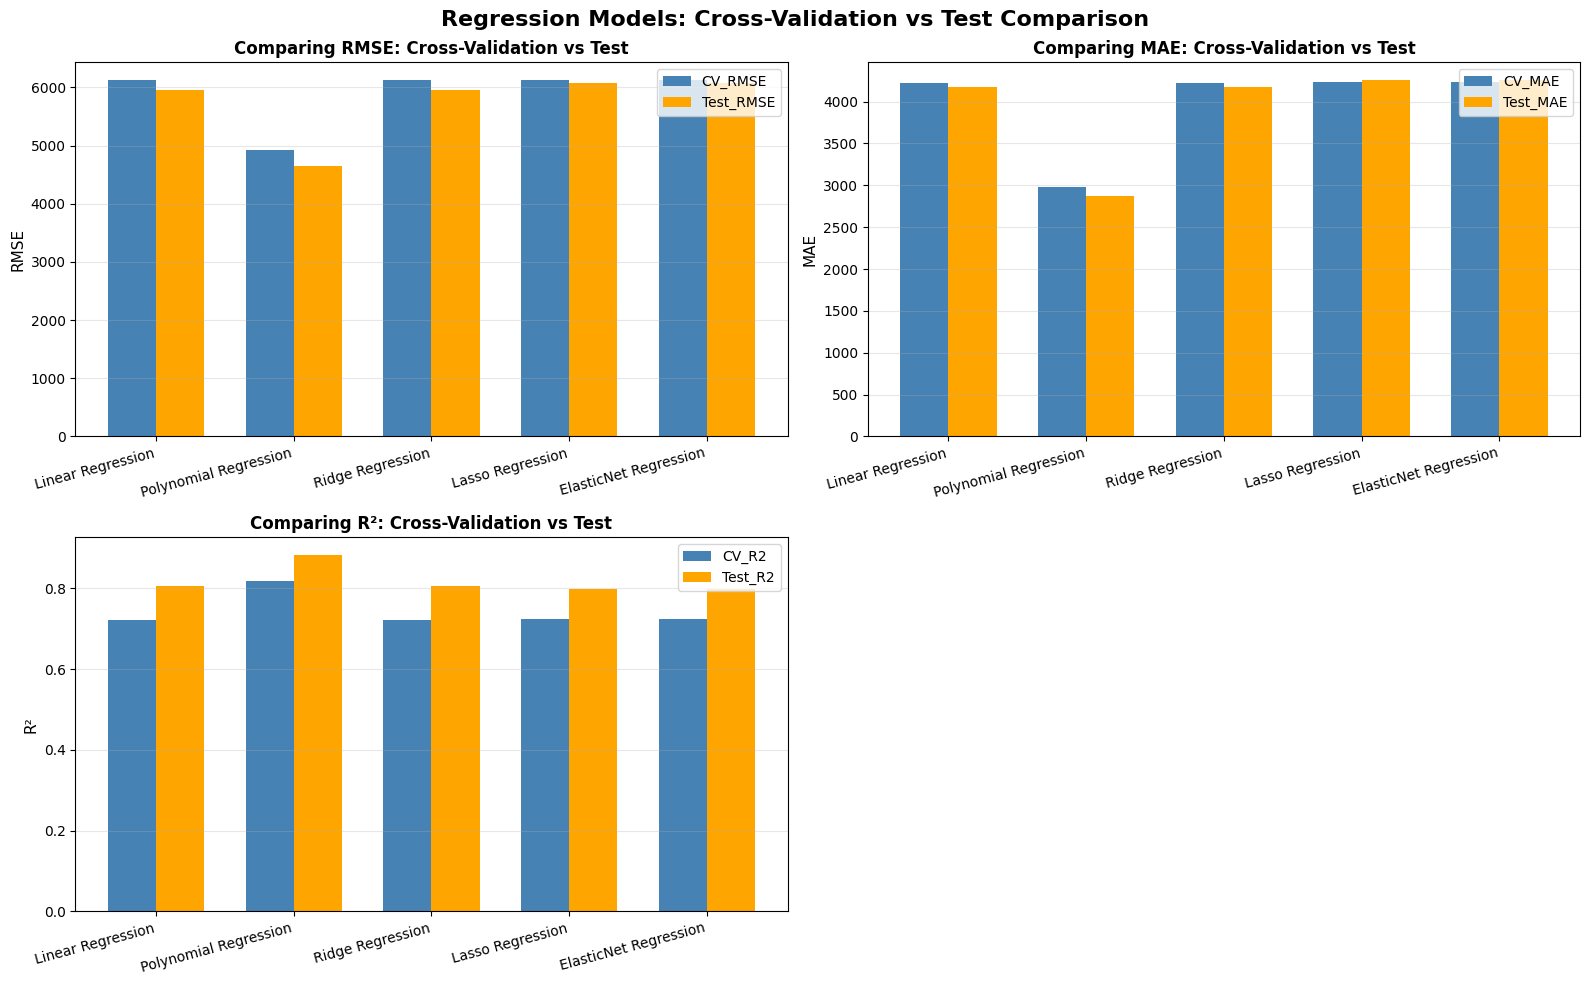

In [23]:
# Visualize CV vs Test comparison for Regression
models_order = [m for m in regression_models.keys()
                if (m in df_cv_reg["Model"].values) and (m in df_test_reg["Model"].values)]

x = np.arange(len(models_order))
width = 0.35

# Create a single figure with 3 subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Regression Models: Cross-Validation vs Test Comparison', fontsize=16, fontweight='bold')
axes = axes.flatten()

# RMSE plot
cv_rmse = [float(df_cv_reg.loc[df_cv_reg["Model"] == m, "CV_RMSE"].values[0]) for m in models_order]
te_rmse = [float(df_test_reg.loc[df_test_reg["Model"] == m, "Test_RMSE"].values[0]) for m in models_order]

axes[0].bar(x - width/2, cv_rmse, width, label="CV_RMSE", color='steelblue')
axes[0].bar(x + width/2, te_rmse, width, label="Test_RMSE", color='orange')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_order, rotation=15, ha='right')
axes[0].set_ylabel("RMSE", fontsize=11)
axes[0].set_title("Comparing RMSE: Cross-Validation vs Test", fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# MAE plot
cv_mae = [float(df_cv_reg.loc[df_cv_reg["Model"] == m, "CV_MAE"].values[0]) for m in models_order]
te_mae = [float(df_test_reg.loc[df_test_reg["Model"] == m, "Test_MAE"].values[0]) for m in models_order]

axes[1].bar(x - width/2, cv_mae, width, label="CV_MAE", color='steelblue')
axes[1].bar(x + width/2, te_mae, width, label="Test_MAE", color='orange')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models_order, rotation=15, ha='right')
axes[1].set_ylabel("MAE", fontsize=11)
axes[1].set_title("Comparing MAE: Cross-Validation vs Test", fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# R² plot
cv_r2 = [float(df_cv_reg.loc[df_cv_reg["Model"] == m, "CV_R2"].values[0]) for m in models_order]
te_r2 = [float(df_test_reg.loc[df_test_reg["Model"] == m, "Test_R2"].values[0]) for m in models_order]

axes[2].bar(x - width/2, cv_r2, width, label="CV_R2", color='steelblue')
axes[2].bar(x + width/2, te_r2, width, label="Test_R2", color='orange')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models_order, rotation=15, ha='right')
axes[2].set_ylabel("R²", fontsize=11)
axes[2].set_title("Comparing R²: Cross-Validation vs Test", fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

# Hide the 4th subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()

### Actual vs Predicted Scatter Plots for All Regression Models

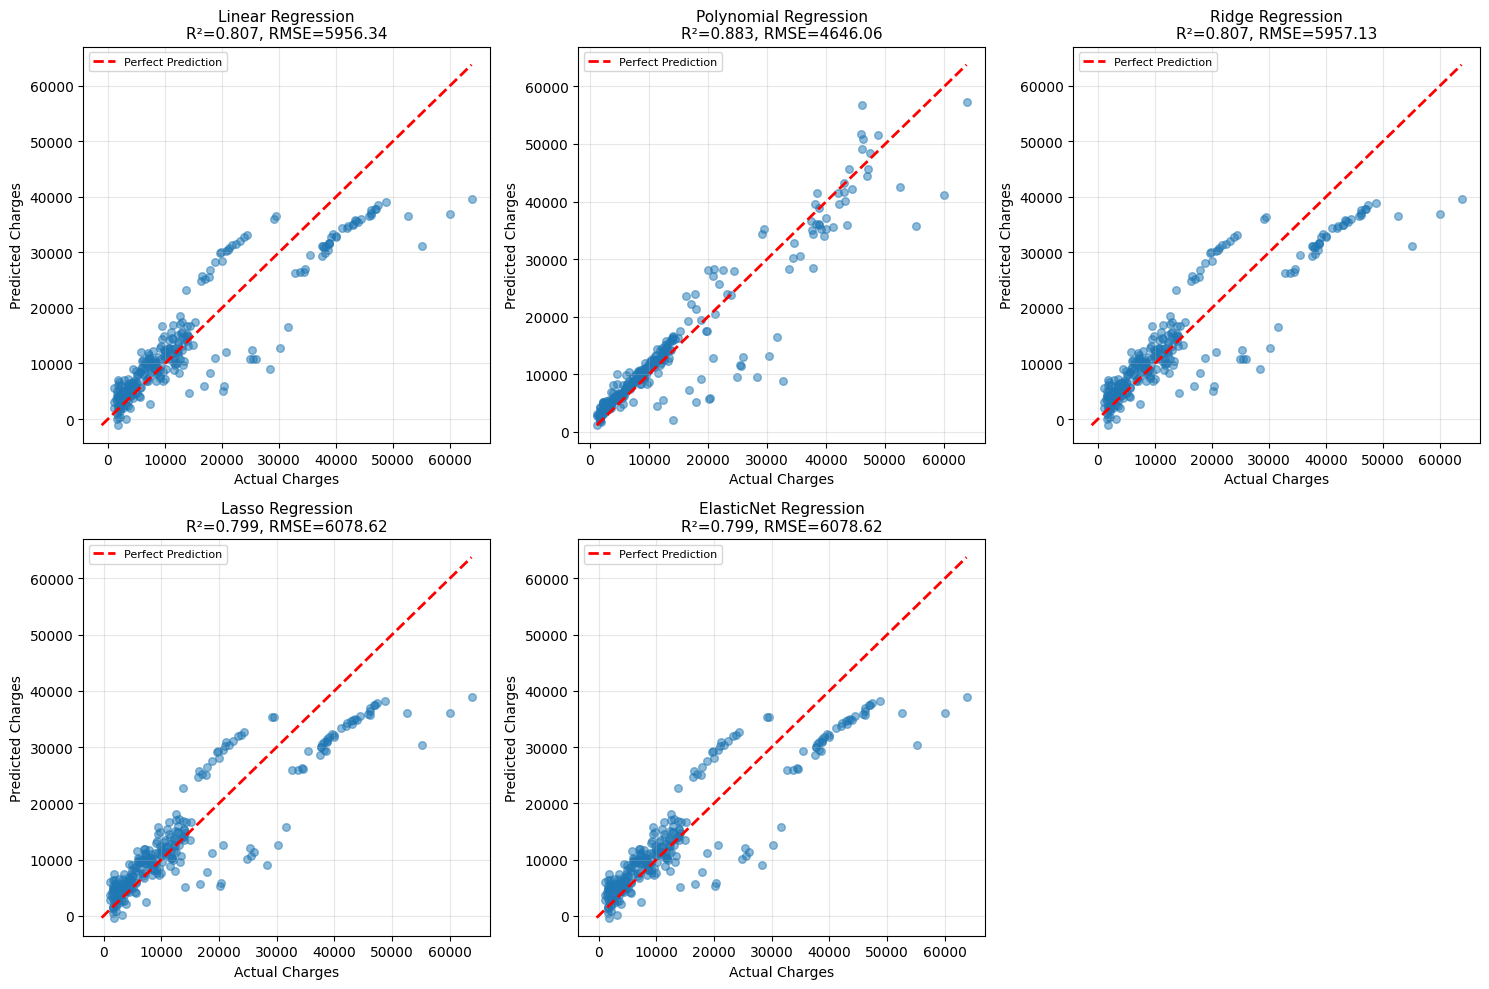

In [24]:
# Actual vs Predicted Scatter Plots for All Regression Models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, name in enumerate(models_order):
    model = regression_models[name]
    y_pred = model.predict(X_test)
    
    # Calculate R² for display
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Scatter plot
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=30)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Charges', fontsize=10)
    axes[idx].set_ylabel('Predicted Charges', fontsize=10)
    axes[idx].set_title(f'{name}\nR²={r2:.3f}, RMSE={rmse:.2f}', fontsize=11)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

# Hide the last subplot if there are only 5 models
if len(models_order) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.show()

### Residual Plots for All Regression Models

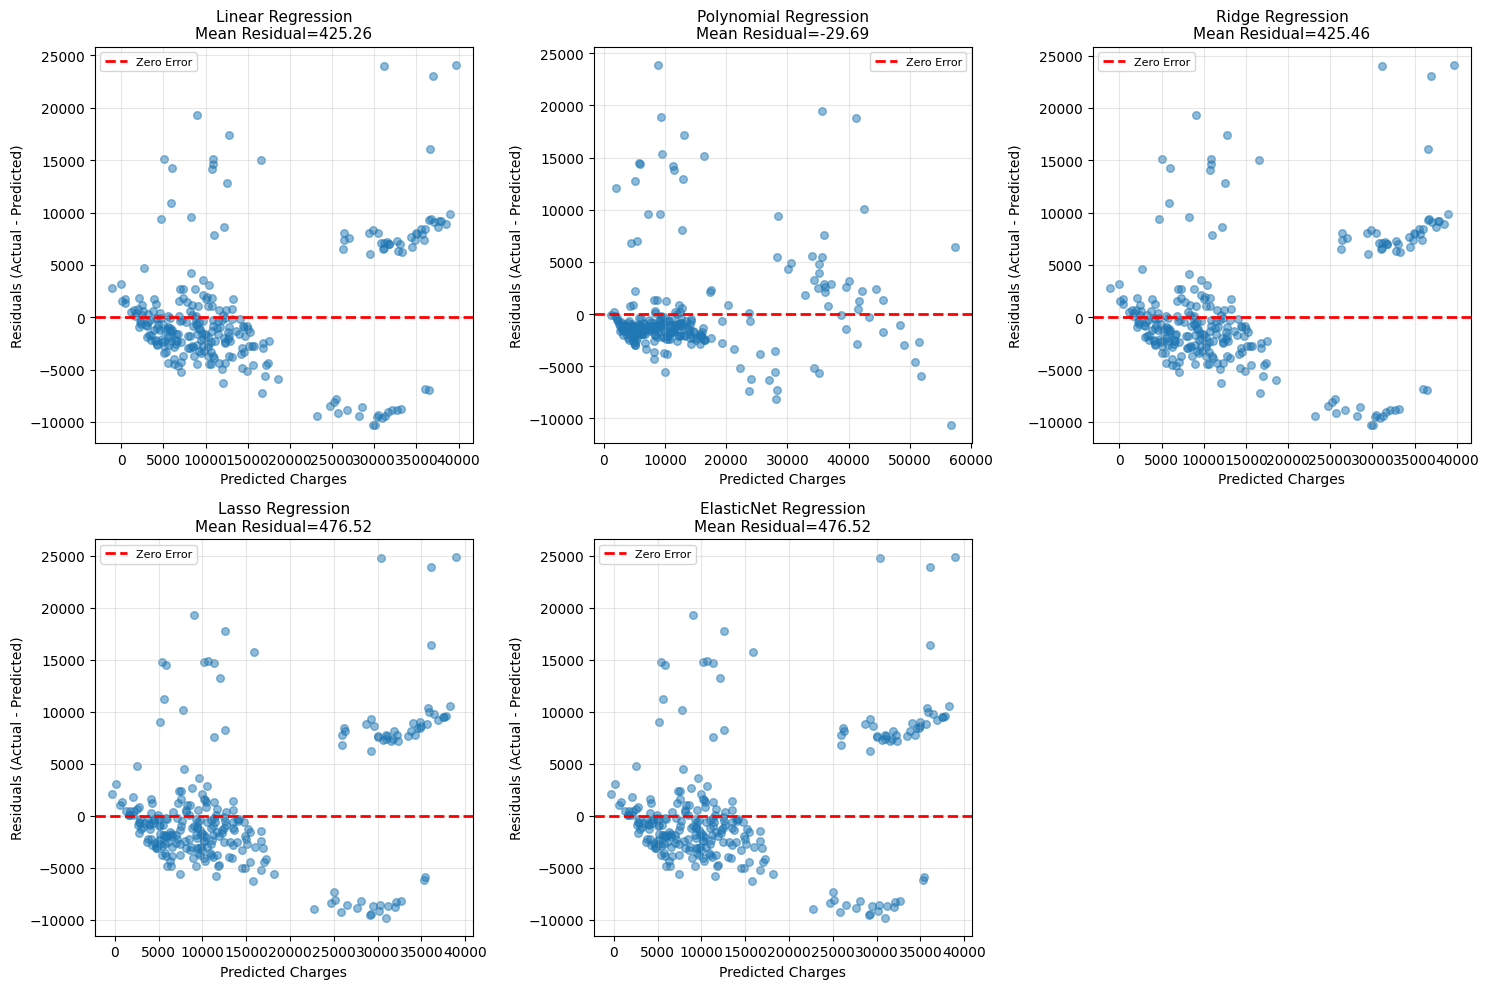

In [25]:
# Residual Plots for All Regression Models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, name in enumerate(models_order):
    model = regression_models[name]
    y_pred = model.predict(X_test)
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Residual plot
    axes[idx].scatter(y_pred, residuals, alpha=0.5, s=30)
    axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    
    axes[idx].set_xlabel('Predicted Charges', fontsize=10)
    axes[idx].set_ylabel('Residuals (Actual - Predicted)', fontsize=10)
    axes[idx].set_title(f'{name}\nMean Residual={residuals.mean():.2f}', fontsize=11)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

# Hide the last subplot if there are only 5 models
if len(models_order) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.show()

## Compare All Classification Models

In [26]:
# Collect results WITHOUT SMOTE (from individual model training)
classification_models = {
    "Logistic Regression": gs_logistic,
    "K-Nearest Neighbors": gs_knn,
    "SVM (RBF)": gs_svm_rbf,
    "SVM (Linear)": gs_svm_linear,
    "Decision Tree": gs_dt,
    "Random Forest": gs_rf,
    "Gradient Boosting": gs_gb
}

classification_results = []
for name, model in classification_models.items():
    y_pred = model.predict(X_test_clf)
    y_pred_proba = model.predict_proba(X_test_clf)[:, 1]
    
    classification_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_clf, y_pred),
        "Precision": precision_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        "F1": f1_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        "ROC_AUC": roc_auc_score(y_test_clf, y_pred_proba)
    })

# Add stacking ensemble results
y_pred_stack = stacking_pipeline.predict(X_test_clf)
y_pred_proba_stack = stacking_pipeline.predict_proba(X_test_clf)[:, 1]
classification_results.append({
    "Model": "Stacking Ensemble",
    "Accuracy": accuracy_score(y_test_clf, y_pred_stack),
    "Precision": precision_score(y_test_clf, y_pred_stack, average='weighted', zero_division=0),
    "Recall": recall_score(y_test_clf, y_pred_stack, average='weighted', zero_division=0),
    "F1": f1_score(y_test_clf, y_pred_stack, average='weighted', zero_division=0),
    "ROC_AUC": roc_auc_score(y_test_clf, y_pred_proba_stack)
})

df_classification = pd.DataFrame(classification_results).sort_values(by="F1", ascending=False)

# Collect results WITH SMOTE
classification_results_smote = []
for name, model in trained_models_smote.items():
    y_pred = model.predict(X_test_clf)
    y_pred_proba = model.predict_proba(X_test_clf)[:, 1]
    
    classification_results_smote.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_clf, y_pred),
        "Precision": precision_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        "F1": f1_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        "ROC_AUC": roc_auc_score(y_test_clf, y_pred_proba)
    })

df_classification_smote = pd.DataFrame(classification_results_smote).sort_values(by="F1", ascending=False)

# Display results
print("\n=== Classification Results WITHOUT SMOTE ===")
print(df_classification.to_string(index=False))
print("\n=== Classification Results WITH SMOTE ===")
print(df_classification_smote.to_string(index=False))


=== Classification Results WITHOUT SMOTE ===
              Model  Accuracy  Precision   Recall       F1  ROC_AUC
K-Nearest Neighbors  0.753731   0.689358 0.753731 0.711818 0.501536
  Gradient Boosting  0.791045   0.701230 0.791045 0.708741 0.435851
       SVM (Linear)  0.794776   0.631669 0.794776 0.703897 0.505548
Logistic Regression  0.794776   0.631669 0.794776 0.703897 0.500000
  Stacking Ensemble  0.794776   0.631669 0.794776 0.703897 0.551729
      Random Forest  0.746269   0.669763 0.746269 0.698890 0.461289
          SVM (RBF)  0.776119   0.628568 0.776119 0.694594 0.550534
      Decision Tree  0.611940   0.644795 0.611940 0.627254 0.428596

=== Classification Results WITH SMOTE ===
              Model  Accuracy  Precision   Recall       F1  ROC_AUC
Logistic Regression  0.794776   0.631669 0.794776 0.703897 0.500000
      Random Forest  0.697761   0.682851 0.697761 0.689934 0.484550
  Gradient Boosting  0.712687   0.670244 0.712687 0.688826 0.496671
       SVM (Linear)  0.6567

### Visualize Metrics Comparison: Before vs After SMOTE

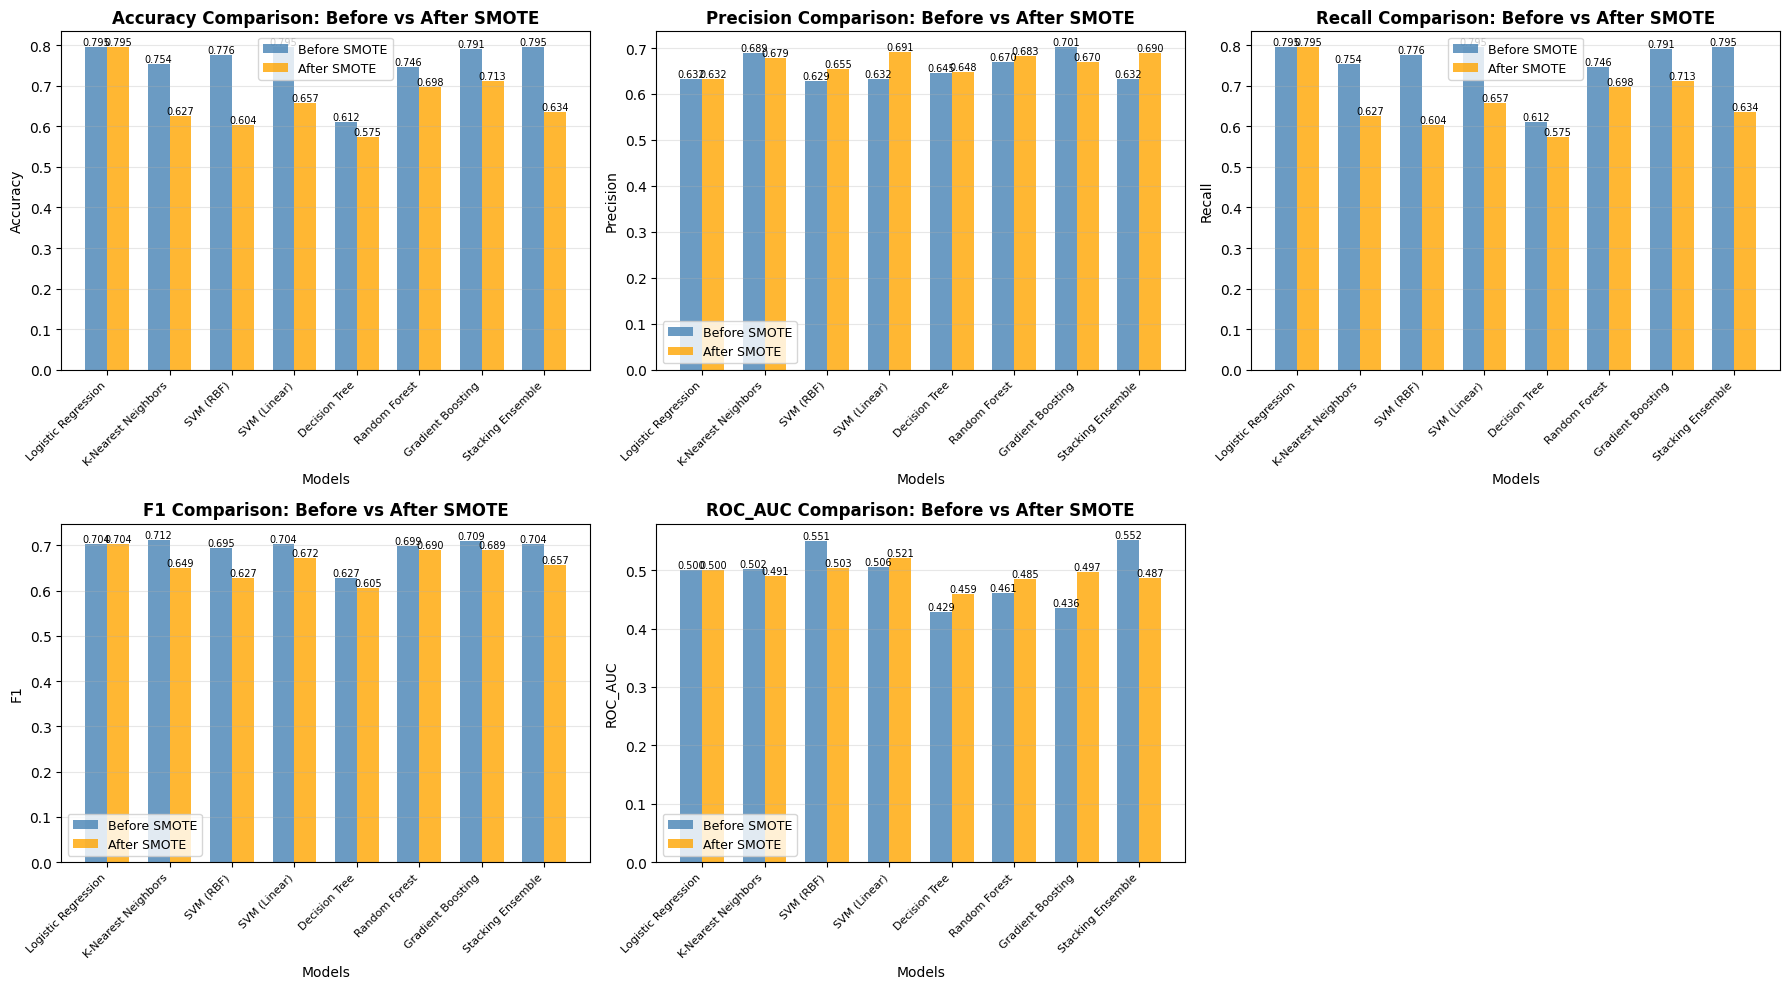

In [27]:
# Prepare data for comparison
models = list(trained_models_smote.keys())
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    # Get values before and after SMOTE
    before_values = [df_classification.loc[df_classification["Model"] == m, metric].values[0] 
                     for m in models]
    after_values = [df_classification_smote.loc[df_classification_smote["Model"] == m, metric].values[0] 
                    for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = axes[idx].bar(x - width/2, before_values, width, label='Before SMOTE', alpha=0.8, color='steelblue')
    bars2 = axes[idx].bar(x + width/2, after_values, width, label='After SMOTE', alpha=0.8, color='orange')
    
    axes[idx].set_xlabel('Models', fontsize=10)
    axes[idx].set_ylabel(metric, fontsize=10)
    axes[idx].set_title(f'{metric} Comparison: Before vs After SMOTE', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=7)
    for bar in bars2:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=7)

# Hide the last subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

### Confusion Matrix Comparison: Before SMOTE

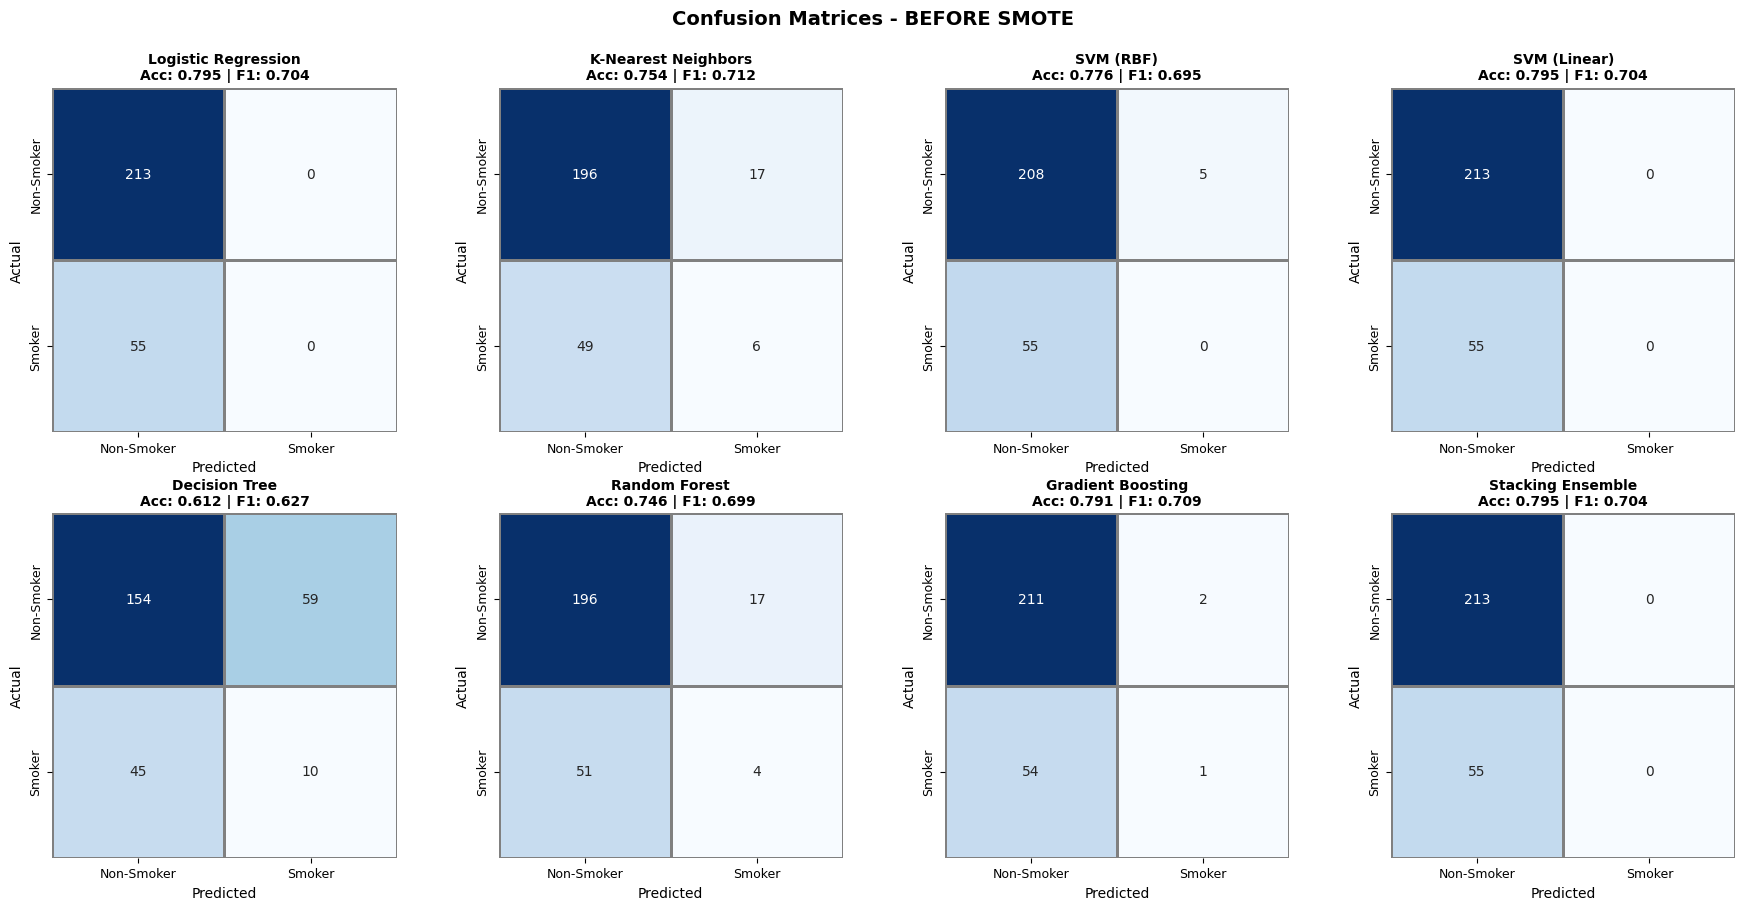

In [28]:
# Confusion Matrices for All Models - BEFORE SMOTE
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

# Collect models without SMOTE
models_before = {
    "Logistic Regression": gs_logistic,
    "K-Nearest Neighbors": gs_knn,
    "SVM (RBF)": gs_svm_rbf,
    "SVM (Linear)": gs_svm_linear,
    "Decision Tree": gs_dt,
    "Random Forest": gs_rf,
    "Gradient Boosting": gs_gb,
    "Stacking Ensemble": stacking_pipeline
}

for idx, (name, model) in enumerate(models_before.items()):
    y_pred = model.predict(X_test_clf)
    cm = confusion_matrix(y_test_clf, y_pred)
    
    # Calculate accuracy for subtitle
    acc = accuracy_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred, average='weighted', zero_division=0)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar=False, square=True, linewidths=1, linecolor='gray')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    axes[idx].set_title(f'{name}\nAcc: {acc:.3f} | F1: {f1:.3f}', fontsize=10, fontweight='bold')
    axes[idx].set_xticklabels(['Non-Smoker', 'Smoker'], fontsize=9)
    axes[idx].set_yticklabels(['Non-Smoker', 'Smoker'], fontsize=9)

plt.suptitle('Confusion Matrices - BEFORE SMOTE', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Confusion Matrix Comparison: After SMOTE

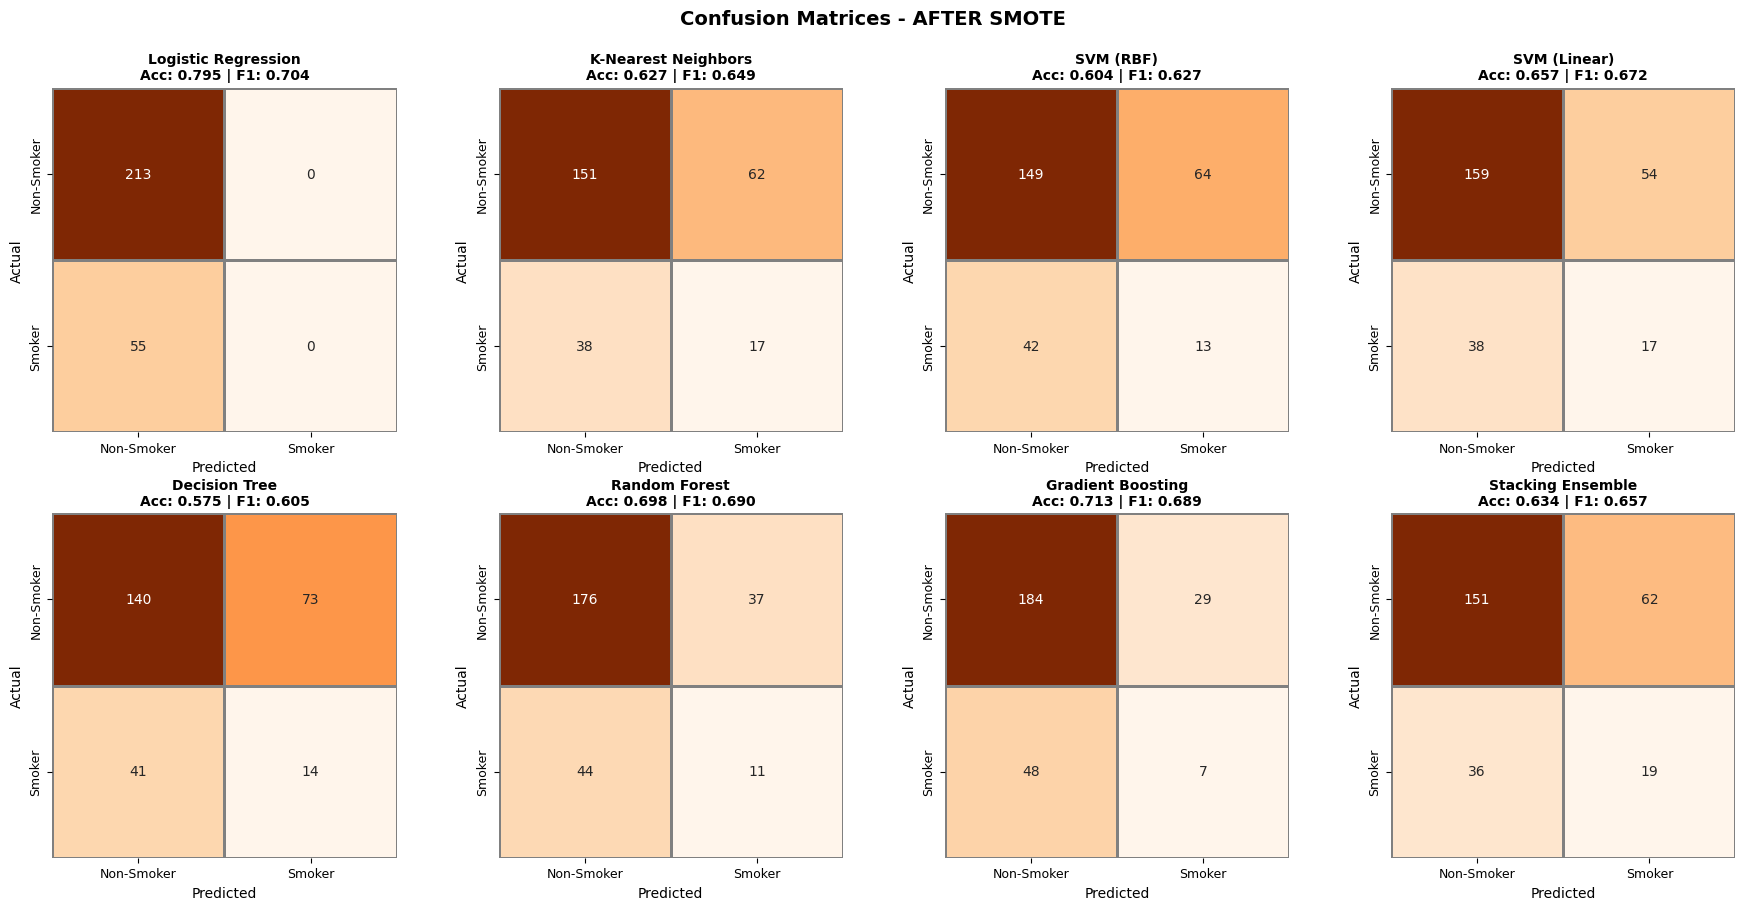

In [29]:
# Confusion Matrices for All Models - AFTER SMOTE
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for idx, (name, model) in enumerate(trained_models_smote.items()):
    y_pred = model.predict(X_test_clf)
    cm = confusion_matrix(y_test_clf, y_pred)
    
    # Calculate accuracy for subtitle
    acc = accuracy_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred, average='weighted', zero_division=0)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[idx], 
                cbar=False, square=True, linewidths=1, linecolor='gray')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    axes[idx].set_title(f'{name}\nAcc: {acc:.3f} | F1: {f1:.3f}', fontsize=10, fontweight='bold')
    axes[idx].set_xticklabels(['Non-Smoker', 'Smoker'], fontsize=9)
    axes[idx].set_yticklabels(['Non-Smoker', 'Smoker'], fontsize=9)

plt.suptitle('Confusion Matrices - AFTER SMOTE', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()